# Description

This notebook can be used to reproduce results form the paper:
"Cross-column DFT-based QSRR model development powered by Machine Learning".

Data (molecular descriptors, column characteristics, and experimental retention times) are loaded, split into training, validation and blind test. QSRR models are built using four ML methods (Ridge Regression, Partial Least Squares, Random Forests and Gradient Boosting). Hyper-parameters of the ML QSRR models are optimized using a grid search.

# Requirements

1. jupyter-notebook
2. numpy
3. pandas
4. matplotlib
5. seaborn
6. scikit-learn
7. shap

# Imports

In [1]:
# Install requirements
%pip install numpy pandas matplotlib seaborn scikit-learn shap

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import (
    Any,
    List
)

import numpy as np

import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import (
    Ridge,
    RidgeCV
)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    scale
)
from sklearn.model_selection import (
    PredefinedSplit,
    train_test_split
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import shap

from src.config import (
    plot_settings,
    split_indices
)

from src.visuals import Visualizer

plt.rcParams.update(plot_settings)

sns.set()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Loading & Processing

In [3]:
# Load Data
_data_df: DataFrame = pd.read_csv(
    './data/2023-07-19-qsrr_dataset.csv'
)

# Drop columns= 'name' and '#', 'ID', "Length"
_data_df.drop(
    columns=['#','name', 'ID', "Length"],
    errors="ignore",
    inplace=True
)

# Display Data
display(_data_df.head())

,SE[kcal/mol],Delta(min)[eV],M(tot.)[D],EnergyGap[eV],Electrophilicity[eV],IP[eV],EA[eV],GlobalHardness[eV],Electronegativity[eV],Electrophilicity [eV],Temperature,Gradient,ParticleSize,Carbon Load,PoreSize,TR
0,-7.440,-0.503,5.3780,8.383,-3.93,8.12,-0.26,4.19,3.93,1.84,25,40,2.7,10,120,15.842
1,-6.145,-0.545,1.7540,7.810,-3.61,7.51,-0.30,3.90,3.61,1.67,25,40,2.7,10,120,30.996
2,-7.669,-0.679,2.4686,8.287,-3.68,7.82,-0.46,4.14,3.68,1.63,25,40,2.7,10,120,12.111
3,-9.395,-0.666,6.9915,9.167,-4.07,8.65,-0.52,4.58,4.07,1.81,25,40,2.7,10,120,4.968
4,-12.792,-0.680,3.8255,7.723,-2.63,6.49,-1.23,3.86,2.63,0.90,25,40,2.7,10,120,12.465


# Data Analysis

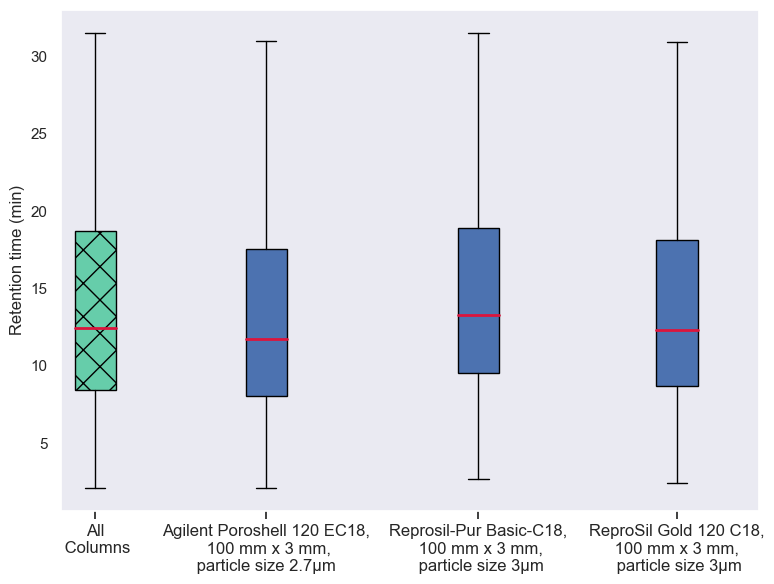

In [4]:
# Retention Times Boxplot

_x: List[Any] = [
    _data_df['TR'],
    _data_df['TR'][_data_df['Carbon Load'] == 10],  # Column 1
    _data_df['TR'][_data_df['Carbon Load'] == 17],  # Column 2
    _data_df['TR'][_data_df['Carbon Load'] == 20]
]

_positions: List[int] = [5, 30, 61, 90]

_labels: List[str] = [
    'All\n Columns',
    'Agilent Poroshell 120 EC18,\n 100 mm x 3 mm,\n particle size 2.7μm ',
    'Reprosil-Pur Basic-C18,\n 100 mm x 3 mm,\n particle size 3μm',
    'ReproSil Gold 120 C18,\n 100 mm x 3 mm, \n particle size 3μm'
]

_y_label: str = 'Retention time (min)'

Visualizer.boxplot(
    x=_x,
    positions=_positions,
    labels=_labels,
    y_label=_y_label
)

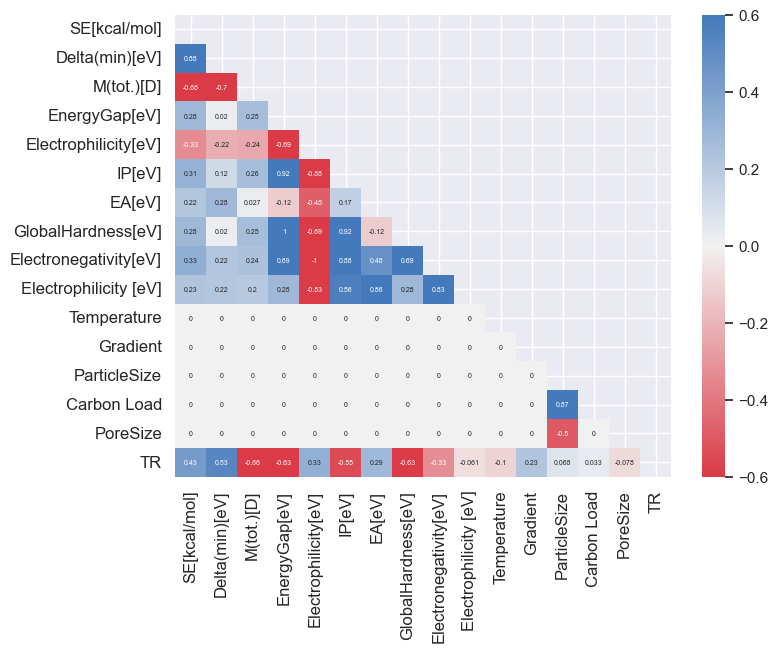

In [5]:
# Correlation Matrix Plot
_correlation_df = _data_df.corr(method='spearman')

Visualizer.correlation_heatmap(
    _correlation_df
)

# Train/Test Split

In [6]:
# X- and y- data
_x = _data_df.iloc[:,:-1].values  # Variables -> x1 to x15
_y = _data_df.iloc[:,-1].values   # Target: -> tR : retention tiime

# Split initial data into training & blind test sets
_x_train_all, _x_bt, _y_train_all, _y_bt = train_test_split(
    _x,
    _y,
    test_size=0.3
    ,shuffle=True,
    random_state=12345  # For reproducibility
)

# Split the training data further into training and validation
_x_train, _x_validation, _y_train, _y_validation = train_test_split(
    _x_train_all,
    _y_train_all,
    test_size=0.3,
    random_state=12345   # For reproducibility
)

# Summary
print('X-train:', _x_train.shape)
print('y-train:', _y_train.shape)
print('- - '*10)
print('X-validation:', _x_validation.shape)
print('y-validation:', _y_validation.shape)
print('- - '*10)
print('X-BT:', _x_bt.shape)
print('y-BT:', _y_bt.shape)
print('- - '*10)

# Using Predefiend Set of data for validation for hyper-parameter optimization
ps = PredefinedSplit(test_fold=split_indices)

X-train: (176, 15)
y-train: (176,)
- - - - - - - - - - - - - - - - - - - - 
X-validation: (76, 15)
y-validation: (76,)
- - - - - - - - - - - - - - - - - - - - 
X-BT: (108, 15)
y-BT: (108,)
- - - - - - - - - - - - - - - - - - - - 


# Hyper-Parameter Optimization & QSRR model building

## model 1 : Random Forest Regression Model
---

In [8]:

#Hyperparameter Tuning
############################################
# Set Param_grid (define the search space)
param_grid = {
    'n_estimators': range(10,210,10),   # 10,20,30, ...,200
    'max_features': [None, 'sqrt'],
    'max_depth': range(2,30,3),   # 2,5,8,...,30
    'min_samples_split': [2, 5, 10,],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
    }

"""    
# Explain each parameter

n_estimators          # number of trees in the random forest
max_features          # number of features in consideration at every split (None - all features used, 'sqrt' - square root of the number of features)
max_depth             # maximum number of levels allowed in each decision tree
min_samples_split     # minimum sample number to split a node
min_samples_leaf      # minimum sample number that can be stored in a leaf node
bootstrap             # method used to sample data points
"""

# build radomforest model
rf = RandomForestRegressor(random_state=12345)

# build GridSearchCV model [scoring: RMSE] -> predefined validation set used.
rf_grid = GridSearchCV(estimator = rf ,param_grid= param_grid, scoring= 'neg_root_mean_squared_error', cv=ps,
                       n_jobs=40, verbose=2, refit=True)
# print model
print ('rf_grid model: ',rf_grid)

rf_grid model:  GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=40,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(2, 30, 3),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(10, 210, 10)},
             scoring='neg_root_mean_squared_error', verbose=2)


In [9]:
# finding best parameters via fitting 
rf_grid.fit(X_tot, y_tot,)

Fitting 1 folds for each of 7200 candidates, totalling 7200 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=40,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(2, 30, 3),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(10, 210, 10)},
             scoring='neg_root_mean_squared_error', verbose=2)

In [10]:
# print the best parameters (results)
print ('Best Parameters: ', rf_grid.best_params_, ' \n')
print ('Best score: ', -rf_grid.best_score_.round(3), ' \n')
bestModel = rf_grid.best_estimator_

Best Parameters:  {'bootstrap': True, 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}  

Best score:  0.486  



[INFO] evaluating...

Model Report
r2_train: 0.999
RMSE_train: 0.183 min
--------------------------------------------------------------------------------
r2_valid: 0.996
RMSE_valid: 0.470 min
--------------------------------------------------------------------------------
r2_test: 0.997
RMSE_test: 0.446 min
--------------------------------------------------------------------------------


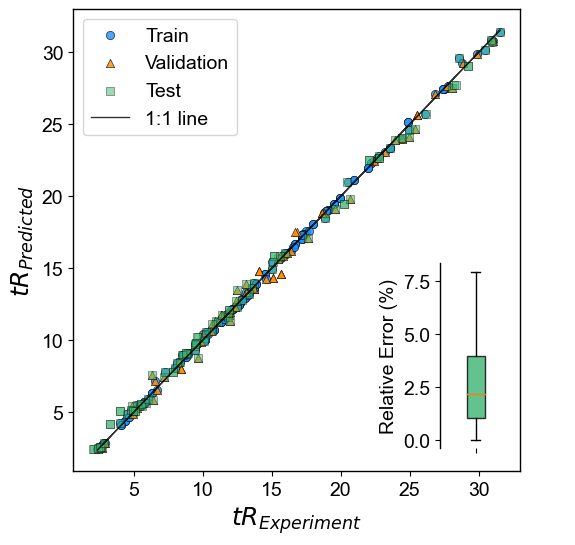

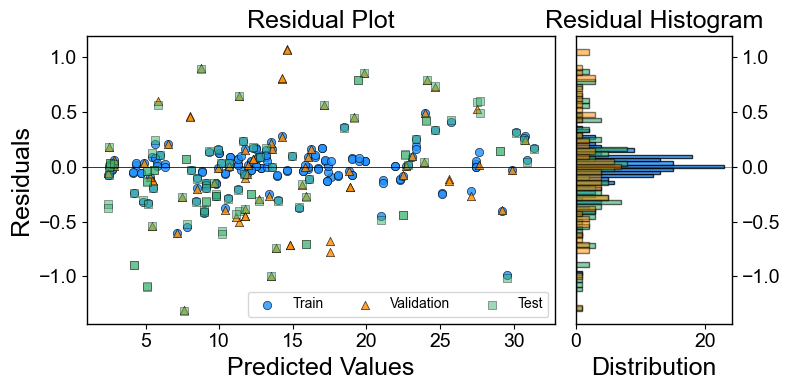

[INFO] Apllicability Domain with william plot Evaluation...


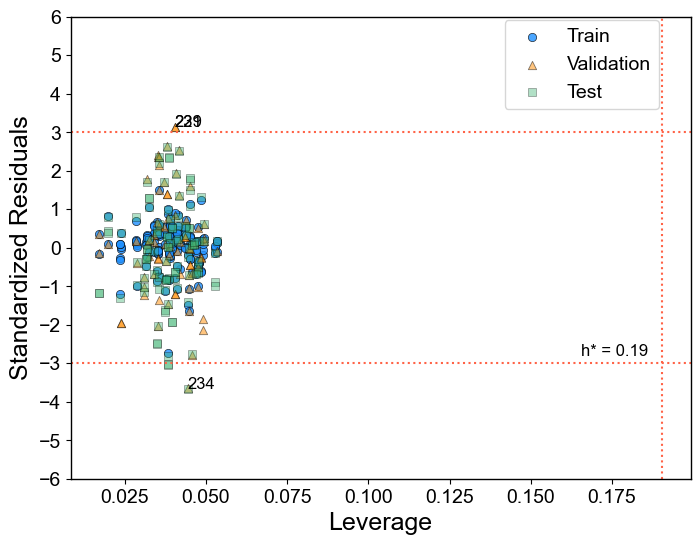

[INFO] Learning curve....


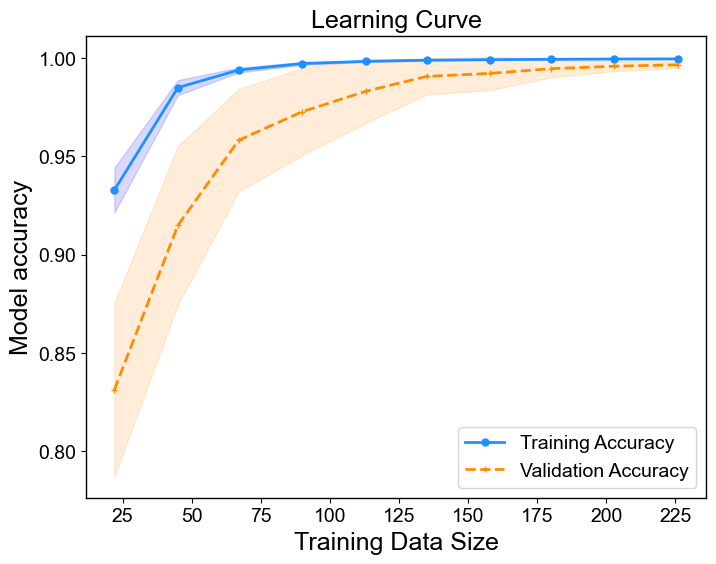

'----------------------------------------------------------------------------------'

In [15]:
# build new model based on best parameters
rf_new = RandomForestRegressor(n_estimators = 70, min_samples_split = 2, min_samples_leaf= 1, max_features = None, 
                               max_depth= 11, bootstrap=True, random_state= 12345) 

"----------------------------------------------------------------------------------"
results (rf_new, title='Random Forest Regression', Y_Random=False)
"----------------------------------------------------------------------------------"


descriptors: 
 Index(['SE[kcal/mol]', 'Delta(min)[eV]', 'M(tot.)[D]', 'EnergyGap[eV]',
       'Electrophilicity[eV]', 'IP[eV]', 'EA[eV]', 'GlobalHardness[eV]',
       'Electronegativity[eV]', 'Electrophilicity [eV]', 'Temperature',
       'Gradient', 'ParticleSize', 'Carbon Load', 'PoreSize'],
      dtype='object')
Target: 
      TR
----------------------------------------


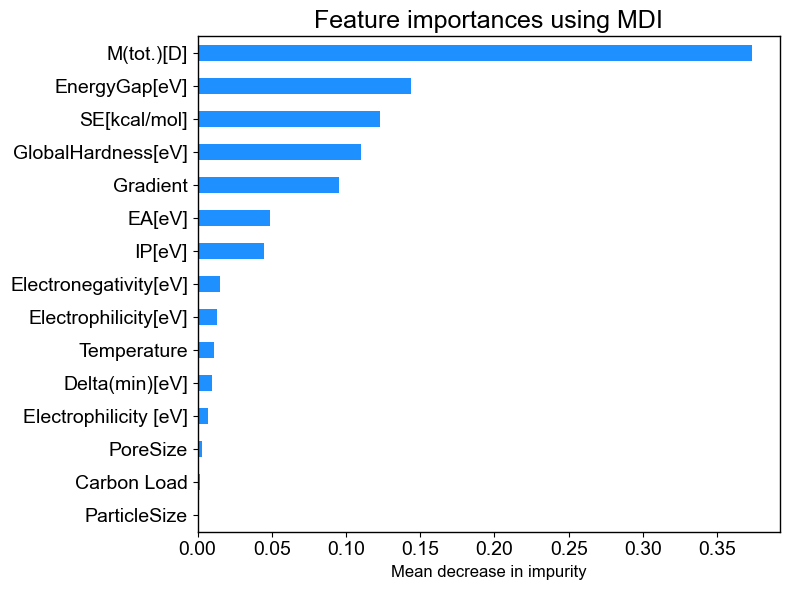

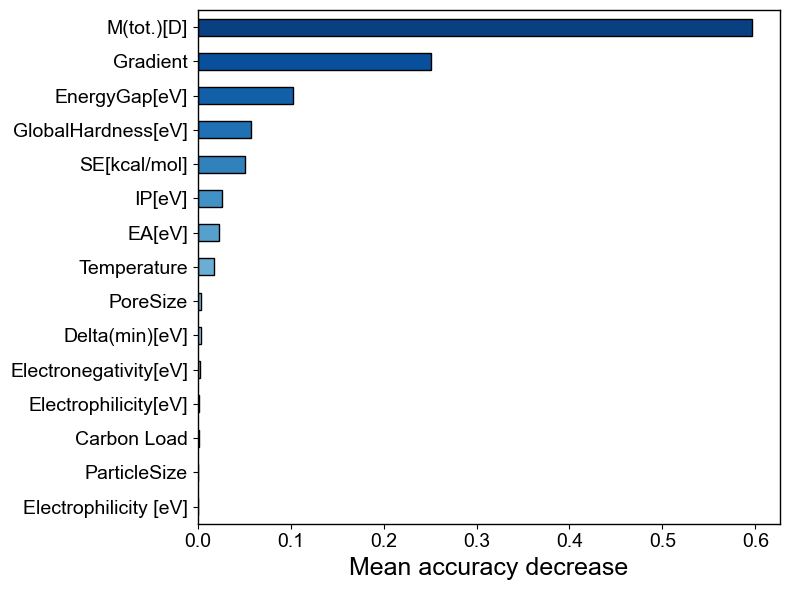

In [12]:
#define list of descriptors and target [X values]
descriptors=df.columns[0:-1]
target=df.columns[-1]
print('descriptors: \n', descriptors)
print('Target: \n     ', target)
print("-"*40)

####################################feature importance#####################################################
# 1) Feature importance based on mean decrease in impurity
importances = rf_new.feature_importances_
forest_importances = pd.Series(importances, index=descriptors).sort_values(ascending=True)

fig = plt.figure(figsize=(8,6))
plt.subplot()
forest_importances.plot.barh(color='dodgerblue')
plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity", fontsize=12)
plt.savefig('./Plots/Random Forest Regression/Feature_importances_MDI.svg', dpi=300, bbox_inches='tight', format='svg')
plt.tight_layout()


# 2)Feature importance based on feature permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_new, X_tot, y_tot, n_repeats=100, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=descriptors).sort_values(ascending=True)
index=forest_importances.index

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot()
pallete=sns.color_palette("Blues",15)
forest_importances.plot.barh(color=pallete , ax=ax1, edgecolor='black')
# ax1.set_title("Feature importances using permutation on full model")
ax1.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('./Plots/Random Forest Regression/Feature_importances_Permutation.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


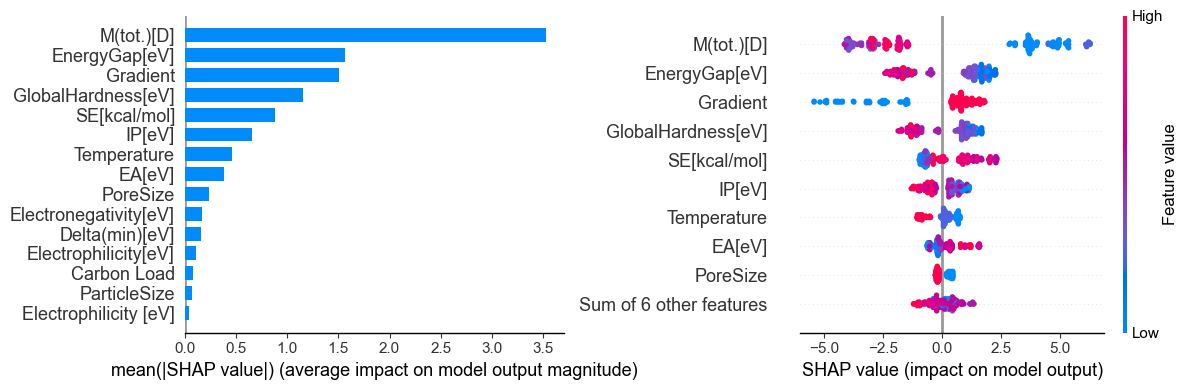

In [13]:
#######################################SHAP PLOTS##############################################

import shap
#   shap.initjs()
fig = plt.figure()

# compute SHAP values
explainer = shap.explainers.Tree(rf_new,X_train,feature_names=descriptors)
shap_values = explainer(X_train,)

ax0 = fig.add_subplot(121)
shap.summary_plot(shap_values, plot_type='bar', feature_names=descriptors, show=False,)

ax2 = fig.add_subplot(122)
shap.plots.beeswarm(shap_values,show=False)

plt.gcf().set_size_inches(12,4)
plt.tight_layout() 
plt.show()

## Model 2: Partial Least squares Regression (PLS-R)
---

 How many latent variables?

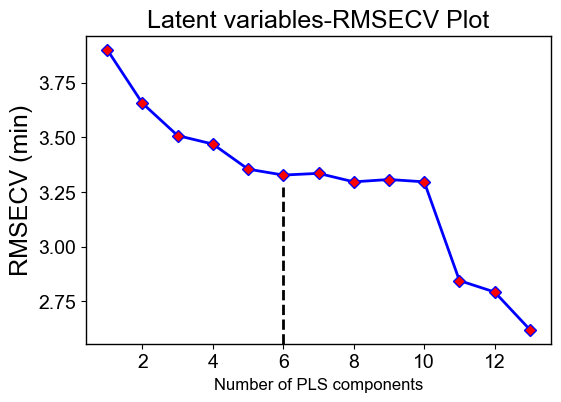

In [14]:
# Number of PLS components -> [1,2,3,...,15]
latent= range(1,14,1)

#loop to calculate error
rmsecv = []
for nc in latent:
    pls = make_pipeline(StandardScaler(), PLSRegression(n_components=nc)) #build pls model 
    kf= KFold(n_splits=10, shuffle=True, random_state=12345) #kfold crossvalidation
    score=cross_val_score(pls,  X_train, y_train,  scoring='neg_root_mean_squared_error', cv=kf) # rmsecv calculation
    rmse=-score.mean() 
    
    rmsecv.append(rmse) # add to -> rmsecv = []

## Visualization of resultss

plt.figure(figsize=[6,4]) 
# Plot
plt.plot(latent, rmsecv,   marker='D', color='blue', mfc='red') # mfc -> marker face color 

# vertical line to show selected number of PLS components(LV)for the model
# lv=4 # number of latent variables
plt.axvline(6, ymax=0.51, linestyle='--' ,color='black')

# labels
plt.xlabel('Number of PLS components', fontsize=12)
plt.ylabel('RMSECV (min)')
plt.title('Latent variables-RMSECV Plot')

plt.show()

# How many latent variables? A: Lv=6

[INFO] evaluating...

Model Report
r2_train: 0.800
RMSE_train: 3.214 min
--------------------------------------------------------------------------------
r2_valid: 0.783
RMSE_valid: 3.385 min
--------------------------------------------------------------------------------
r2_test: 0.808
RMSE_test: 3.631 min
--------------------------------------------------------------------------------


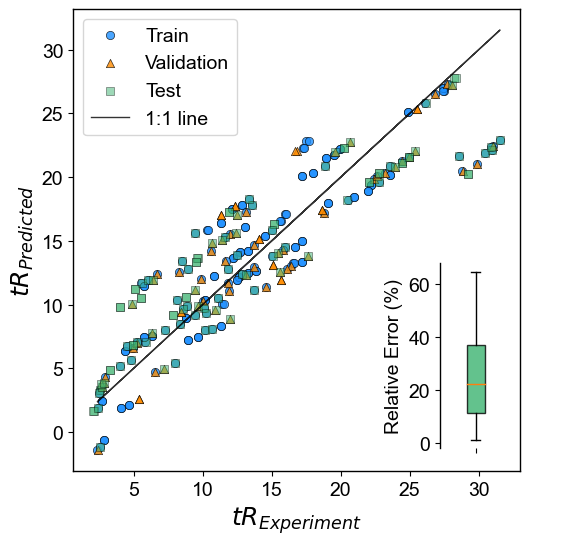

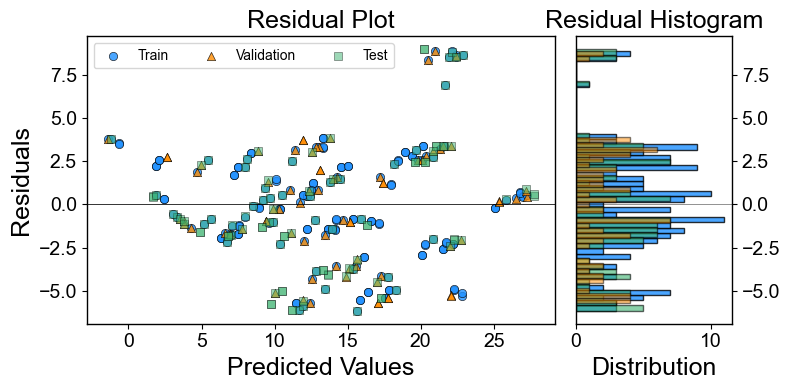

[INFO] Apllicability Domain with william plot Evaluation...


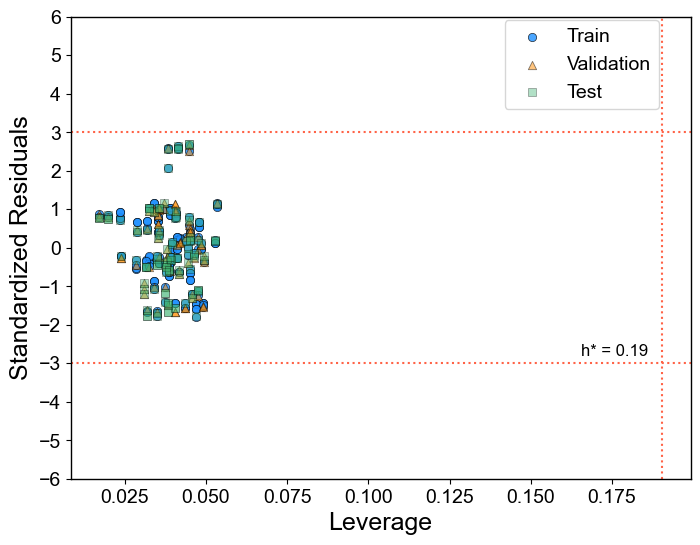

[INFO] Learning curve....


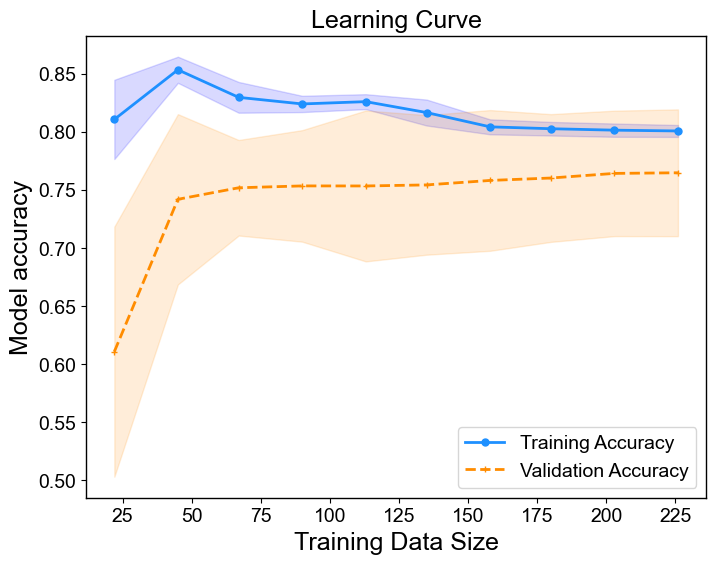

'----------------------------------------------------------------------------------'

In [16]:
# build model using pipeline:  data are standard scaled  ->  fit Pls model

# set number of PLS components (LVs) "number of pls components selected in pervious cell"
n_comp=6  
# build model  
pls = make_pipeline(StandardScaler(), PLSRegression(n_components=n_comp))

"----------------------------------------------------------------------------------"
results (pls, title='PLS-R', reshape=True)
"----------------------------------------------------------------------------------"

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


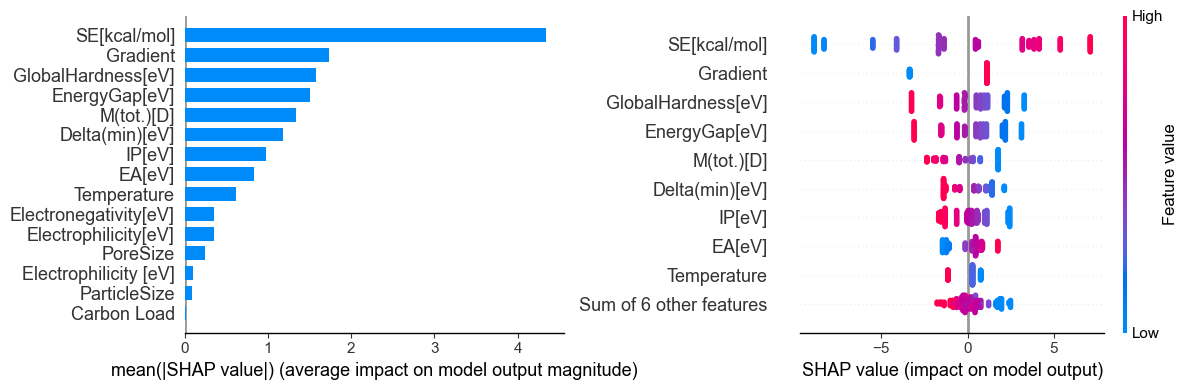

In [16]:
#   shap.initjs()
fig = plt.figure()

# compute SHAP values
explainer = shap.Explainer(pls.predict,X_train,feature_names=descriptors)
shap_values = explainer(X_train,)

ax0 = fig.add_subplot(121)
shap.summary_plot(shap_values, plot_type='bar', feature_names=descriptors, show=False)

ax2 = fig.add_subplot(122)
shap.plots.beeswarm(shap_values,show=False)

plt.gcf().set_size_inches(12,4)
plt.tight_layout() 
plt.show()


Pls coefficients: 
 
 [[ 5.09206837 -1.25822151 -1.49812998 -1.72215227  0.53335354 -1.22389778
   0.95350211 -1.80752148 -0.53335354  0.13322138 -0.71753758  1.99858943
   0.09333922  0.01432442 -0.25405816]]
--------------------------------------------------------------------------------


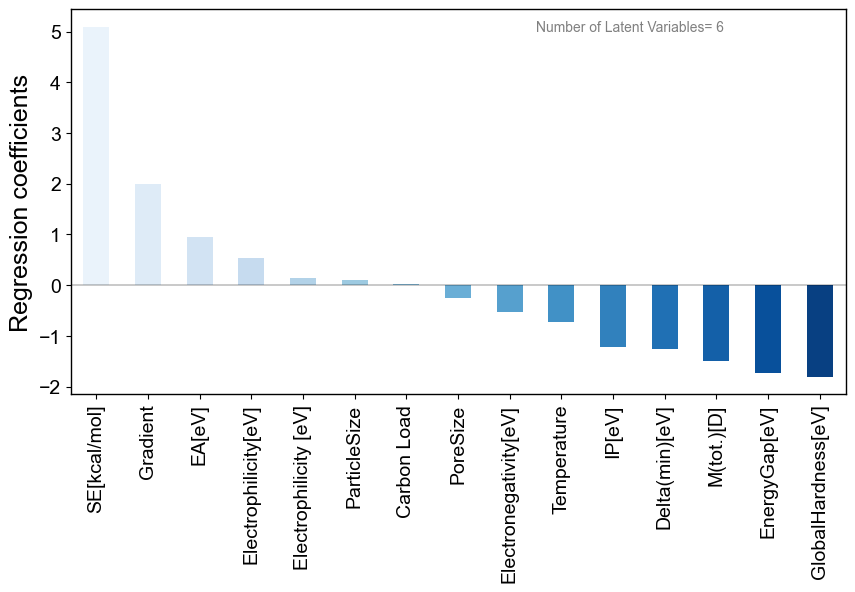

In [17]:
# Coefficient Plot
# regression coefficient [ Y values]: pls.coef_
pls_coef= pls.named_steps['plsregression'].coef_ 
print('Pls coefficients: \n \n',pls_coef)
print("-"*80)

# another Method
pls_coef_ = pd.Series(pls_coef.ravel(), index=descriptors).sort_values(ascending=False)
fig = plt.figure(figsize=(10,5))
ax1=plt.subplot()
pallete=sns.color_palette("Blues",15)
pls_coef_.plot.bar(color=pallete , ax=ax1)

#  labeles
plt.axhline(0, color='black', lw=0.3)
# plt.xlabel("descriptors")
plt.ylabel("Regression coefficients")
plt.annotate('Number of Latent Variables= 6',xy =(1, 2),xytext =(8.5, 5), color='grey')
# plt.title('regression coefficient plot')
plt.show()

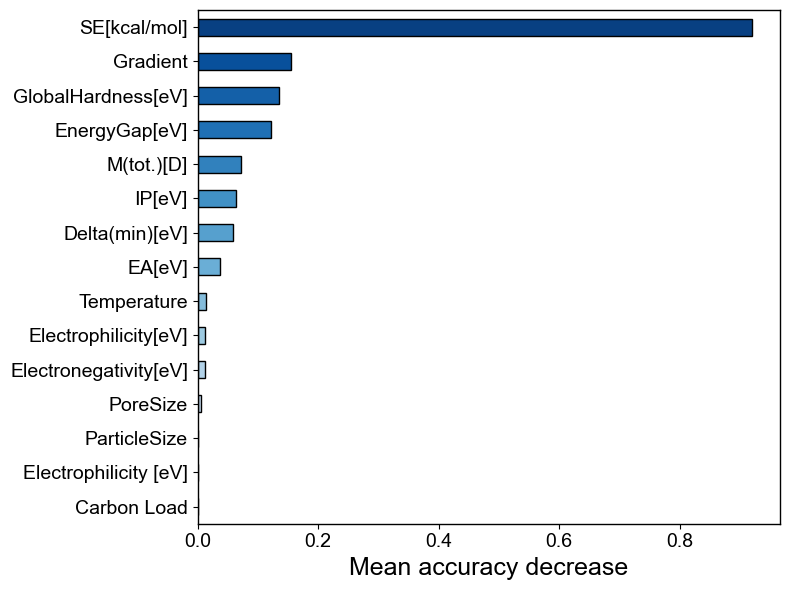

In [18]:
result = permutation_importance(
    pls, X_tot, y_tot, n_repeats=1000, random_state=42, n_jobs=2)

pls_importances = pd.Series(result.importances_mean, index=descriptors).sort_values(ascending=True)
index=pls_importances.index

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot()
pallete=sns.color_palette("Blues",15)
pls_importances.plot.barh(color=pallete , ax=ax1, edgecolor='black')
# ax1.set_title("Feature importances using permutation on full model")
ax1.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('./Plots/PLS-R/PLS_permutation_importance.svg', dpi=300, bbox_inches='tight',format='svg')
plt.show()

## Model 3: Gradient Boosting Regression
---

In [20]:
#Hyperparameter Tuning
# Set Param_grid (define the search space)
param_grid = {
    'n_estimators': np.arange(10,210,10),
    'learning_rate':[.001,0.01,.1],
    'max_features': [None, 'sqrt'],
    'max_depth': range(1, 6, 1),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    }

# Explain each parameter
"""    
n_estimators          # number of trees in the random forest
learning_rate         # The learning rate is the weight that each tree has on the final prediction. 
max_features          # number of features in consideration at every split
max_depth             # maximum number of levels allowed in each decision tree -
min_samples_split     # minimum sample number to split a node
min_samples_leaf      # minimum sample number that can be stored in a leaf node
                             
"""


# build gradient boosting model
GB=GradientBoostingRegressor(random_state=12345)

# build GridSearchCV model
GB_grid = GridSearchCV(estimator = GB ,param_grid= param_grid, scoring='neg_root_mean_squared_error', cv=ps,
                       n_jobs=30, verbose=1)
# print model
print ('GB_grid model: ',GB_grid)

GB_grid model:  GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=30,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(1, 6),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='neg_root_mean_squared_error', verbose=1)


In [23]:
# finding best parameters via fitting 
GB_grid.fit(X_tot, y_tot)

Fitting 1 folds for each of 5400 candidates, totalling 5400 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=30,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(1, 6),
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [24]:
# print the best parameters (results)
print ('Best Parameters: ', GB_grid.best_params_, ' \n')
print ('Best score: ', -GB_grid.best_score_, ' \n')

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}  

Best score:  0.2048698872852287  



[INFO] evaluating...

Model Report
r2_train: 1.000
RMSE_train: 0.067 min
--------------------------------------------------------------------------------
r2_valid: 0.999
RMSE_valid: 0.191 min
--------------------------------------------------------------------------------
r2_test: 0.999
RMSE_test: 0.279 min
--------------------------------------------------------------------------------


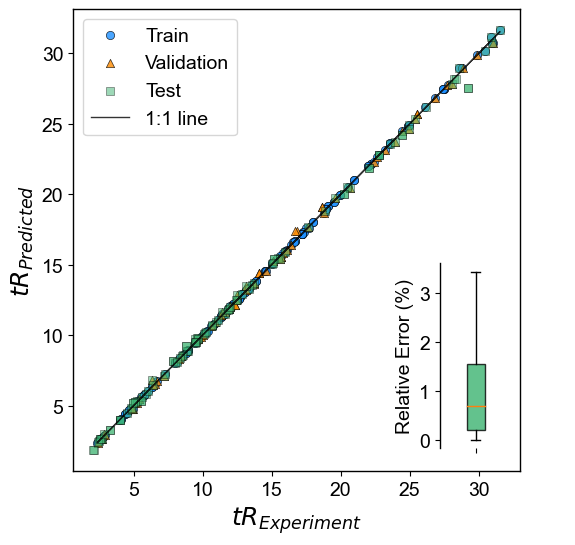

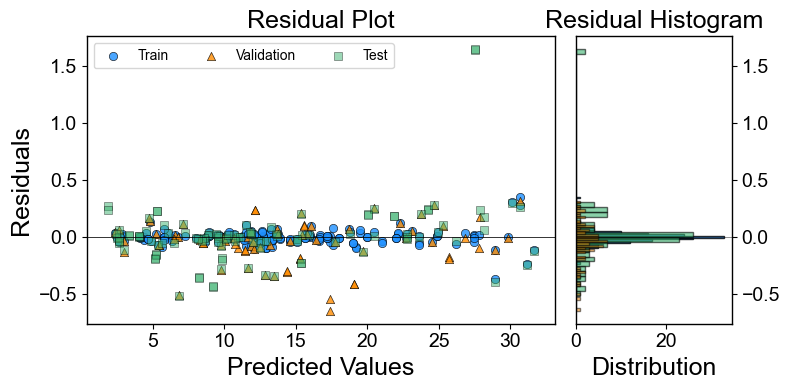

[INFO] Apllicability Domain with william plot Evaluation...


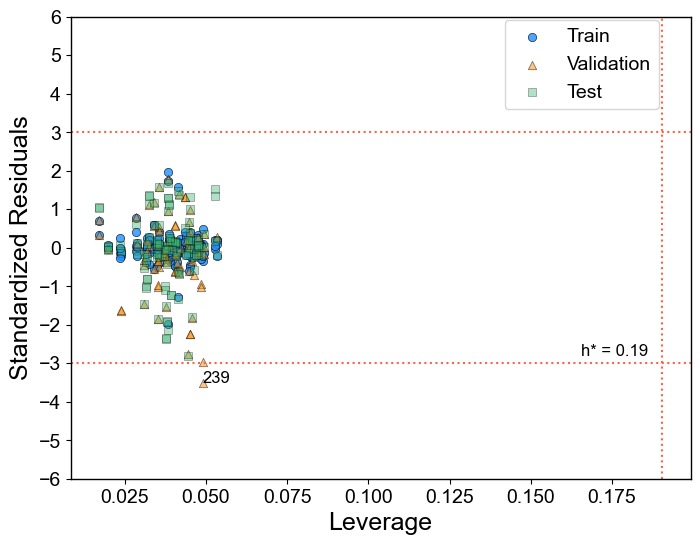

[INFO] Y-randomization Evaluation...
Average score after 1000 iteration: 9.098257878023952


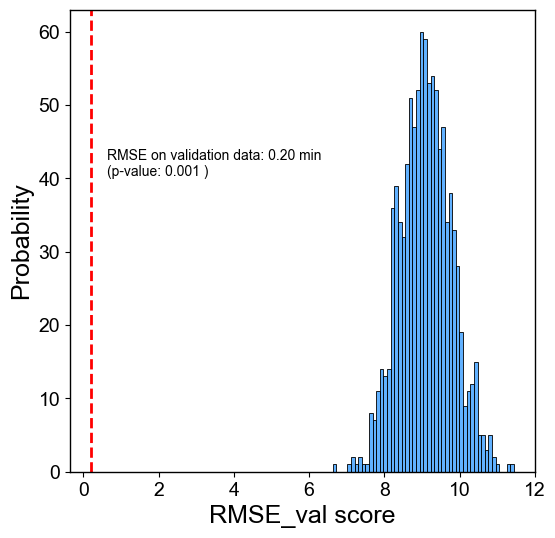

[INFO] Learning curve....


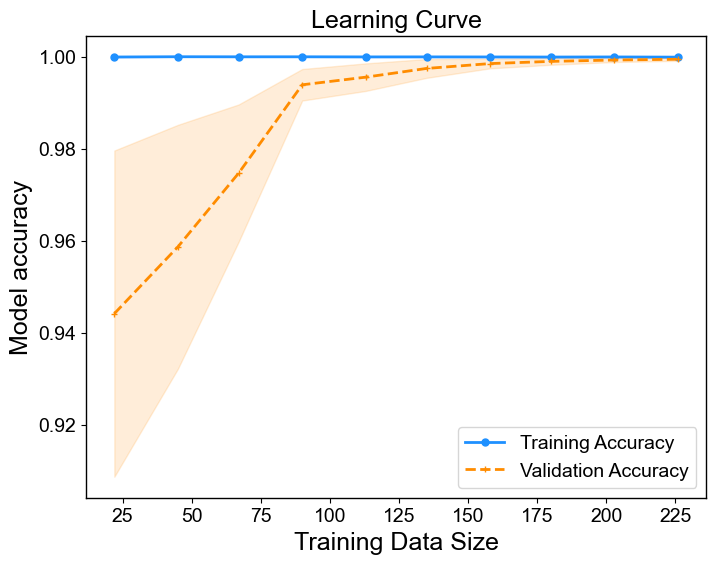

In [17]:
# build new model based on best parameters
GB_new =GradientBoostingRegressor(n_estimators =200,learning_rate=0.1, min_samples_split =5, min_samples_leaf=1, max_features = 'sqrt', 
                               max_depth= 4, random_state=12345,)
                               
"----------------------------------------------------------------------------------"
results (GB_new, title='Gradient Boosting Regression', Y_Random=True)
"----------------------------------------------------------------------------------"

###################   save model  #########################
from joblib import dump, load
#save
model_name='GBModel_Rt_Prediction.z'
dump(GB_new, model_name)

#for load model
my_model=load(model_name)




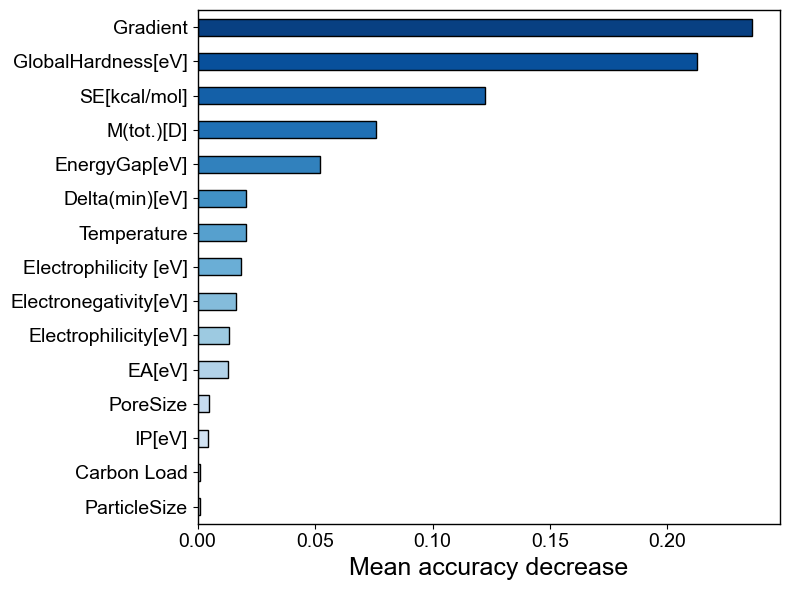

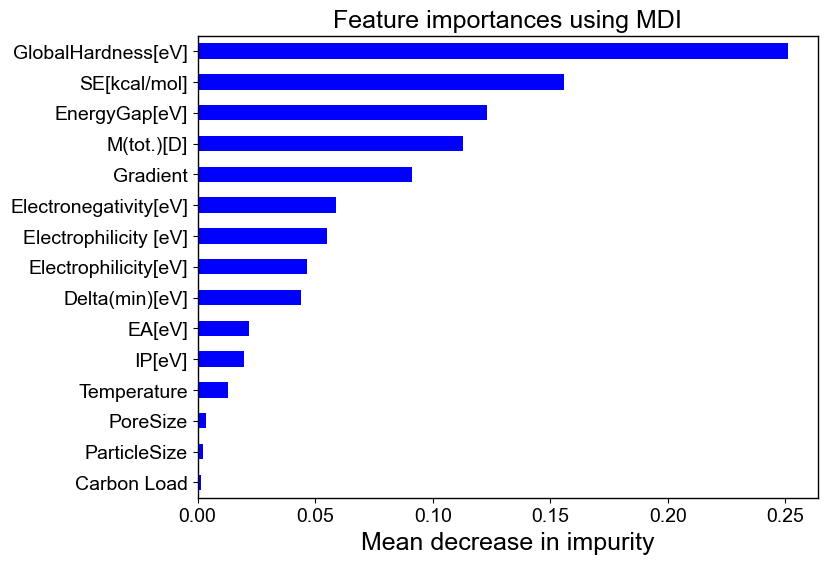

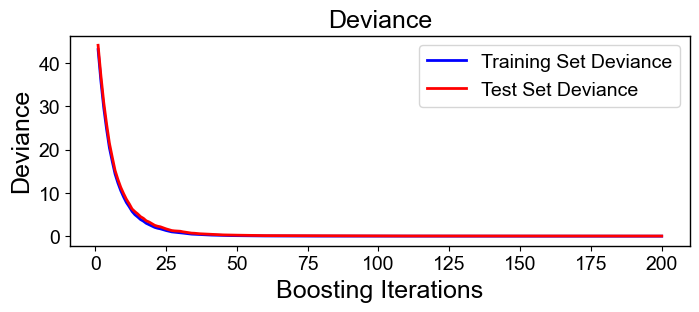

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


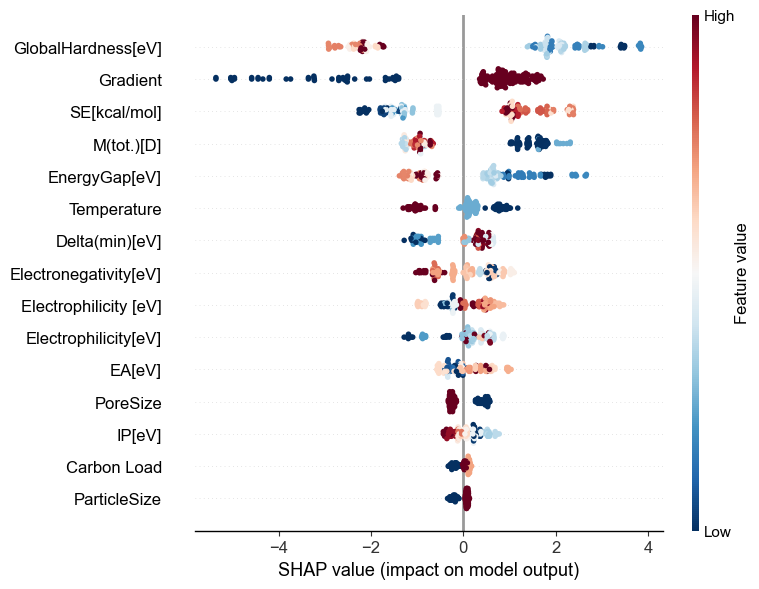

In [28]:
#feature importance#####################################################################
result = permutation_importance(
    GB_new, X_train, y_train, n_repeats=1000, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=descriptors).sort_values(ascending=True)


fig, ax = plt.subplots(figsize=(8,6))
pallete=sns.color_palette("Blues",15)
forest_importances.plot.barh(color=pallete,ax=ax, edgecolor='black')
# ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('./Plots/Gradient Boosting Regression/feature_importance_GB_new.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()


importances = GB_new.feature_importances_
GB_importances = pd.Series(importances, index=descriptors).sort_values(ascending=True)

fig = plt.figure(figsize=(8,6))

# plt.subplot(211)
GB_importances.plot.barh(color='blue')

plt.title("Feature importances using MDI")
plt.xlabel("Mean decrease in impurity")
# plt.tight_layout()
plt.show()

# deviance###########################################################################
n_estimators=200
test_score = np.zeros((n_estimators,), dtype=np.float64)

#for loop
for i, y_pred in enumerate(GB_new.staged_predict(X_valid)):
    test_score[i] = mean_squared_error(y_valid, y_pred)
    
plt.subplot(212)
plt.title("Deviance")

#train set
plt.plot(
    np.arange(n_estimators) + 1,
    GB_new.train_score_,
    "b-",
    label="Training Set Deviance",)

# validation set
plt.subplot(212)
plt.plot(
    np.arange(n_estimators) + 1,
    test_score,
    "r-", 
    label="Test Set Deviance")

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
"---------------------------------------------"
fig.tight_layout()
plt.show()

#SHAP PLOTS#############################################################################

import shap
# compute SHAP values
explainer = shap.explainers.Tree(GB_new,X_train,feature_names=descriptors)
shap_values = explainer(X_train,)

shap.summary_plot(shap_values, feature_names=descriptors, show=False,cmap=plt.get_cmap("RdBu_r"))

# make fontsize smaller:
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(8, 6)
plt.xticks(fontsize=12, )
plt.yticks(fontsize=12,c='black')
plt.tight_layout()
plt.savefig('./Plots/Gradient Boosting Regression/SHAP_GB.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

## Model 4: Ridge Regression
---

In [29]:
# Selecting The Best Alpha Value In Ridge Regression

# build model using pipeline:  data are standard scaled  ->  fit RidgeCV() model

rg = make_pipeline(
    StandardScaler(), 
    RidgeCV(
        alphas= [0.01,0.1,1,10,50,100,200], 
        scoring= 'neg_root_mean_squared_error',
        cv=ps)
    )

print(rg)

# fit to find best alpha
rg.fit(X_tot, y_tot)
print("-"*80)

# show best value for alpha
print('best alpha :',  rg.named_steps['ridgecv'].alpha_)
print('best score [RMSE_eval]: ',  -rg.named_steps['ridgecv'].best_score_)
# print('best score [RMSE_eval]: ',  rg.named_steps['ridgecv'].coef_)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=[0.01, 0.1, 1, 10, 50, 100, 200],
                         cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                         scoring='neg_root_mean_squared_error'))])
--------------------------------------------------------------------------------
best alpha : 0.01
best score [RMSE_eval]:  3.095967643127587


[INFO] evaluating...

Model Report
r2_train: 0.828
RMSE_train: 2.985 min
--------------------------------------------------------------------------------
r2_valid: 0.818
RMSE_valid: 3.097 min
--------------------------------------------------------------------------------
r2_test: 0.832
RMSE_test: 3.395 min
--------------------------------------------------------------------------------


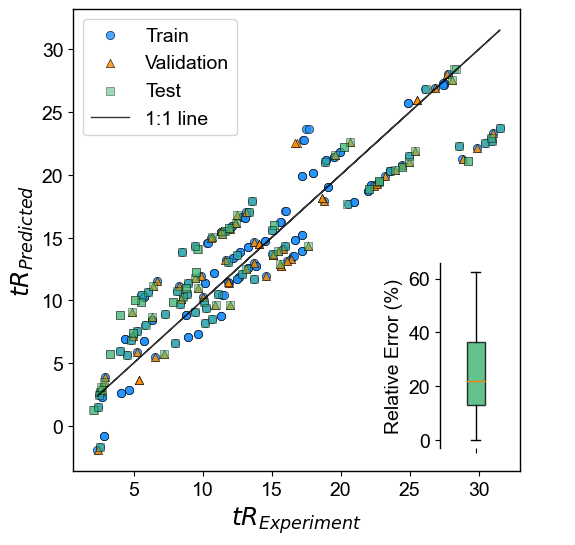

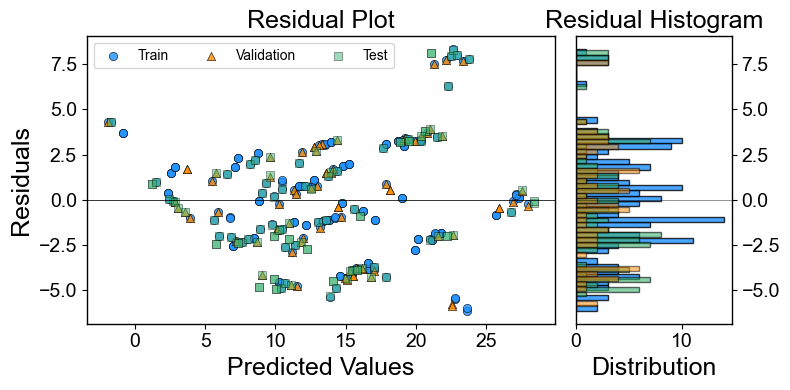

[INFO] Apllicability Domain with william plot Evaluation...


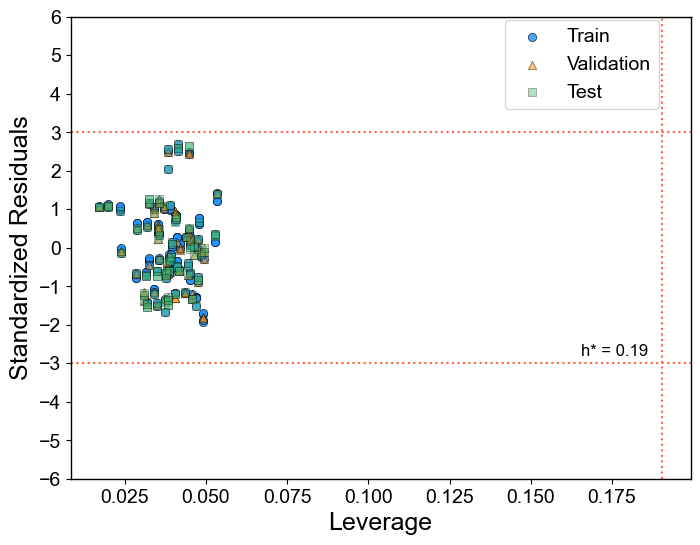

[INFO] Learning curve....


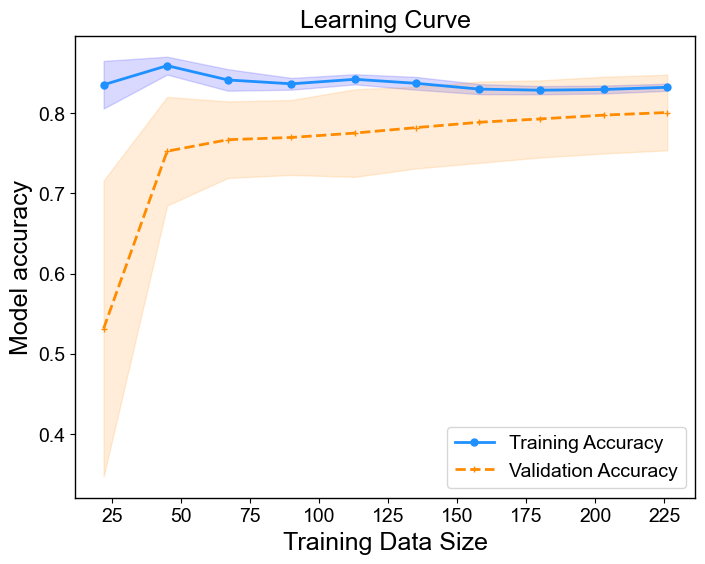

'----------------------------------------------------------------------------------'

In [18]:
# build model using pipeline:  data are standard scaled  ->  fit ridge() model

alpha=0.01  # set Optimal value for alpha selected in pervious cell"
rg_new = make_pipeline(StandardScaler(), Ridge(alpha=alpha))

"----------------------------------------------------------------------------------"
results (rg_new, title='Ridge Regression')
"----------------------------------------------------------------------------------"

Ridge coefficients: 
 
 [ 6.26323499e+00 -1.05329244e+00 -4.54537080e-01 -2.29752106e+01
 -2.87270791e+01  1.40720069e+01 -6.35737109e+01 -4.98610637e+01
  2.87270791e+01  5.54274678e+00 -6.08614204e-01  1.94493899e+00
  1.18363251e-01 -1.12172386e-02 -4.04968690e-01]
--------------------------------------------------------------------------------


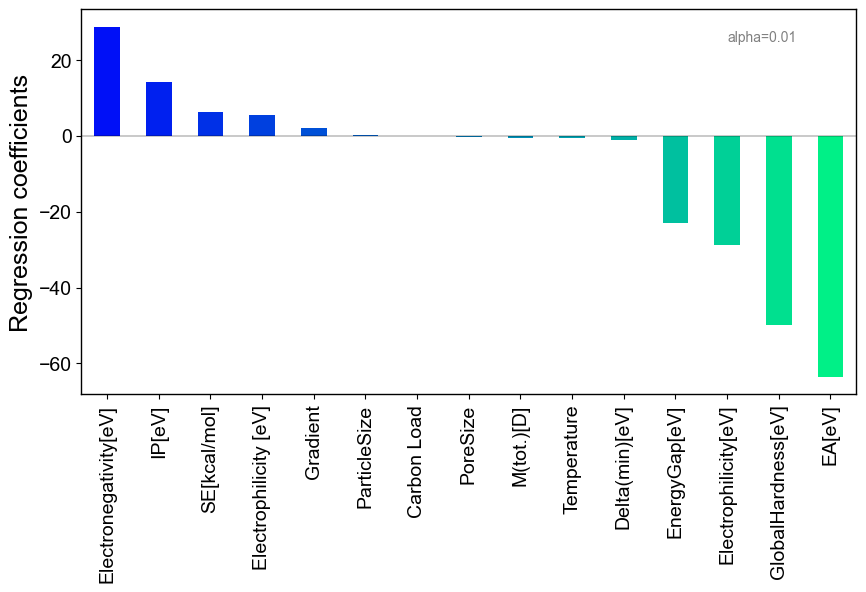

In [31]:
# Coefficient Plot
# regression coefficient [ Y values]: pls.coef_
rg_coef= rg_new.named_steps['ridge'].coef_
print('Ridge coefficients: \n \n',rg_coef)
print("-"*80)


# # another Method
rg_coef_ = pd.Series(rg_coef.ravel(), index=descriptors).sort_values(ascending=False)
fig = plt.figure(figsize=(10,5))
ax1=plt.subplot()
pallete=sns.color_palette("winter",15)
rg_coef_.plot.bar(color=pallete , ax=ax1)

# #  labeles
plt.axhline(0, color='black', lw=0.3)
# plt.xlabel("descriptors")
plt.ylabel("Regression coefficients")
# plt.title('regression coefficient plot\n alpha=0.01')
plt.annotate('alpha=0.01',xy =(1, 2),xytext =(12, 25), color='grey')
plt.show()

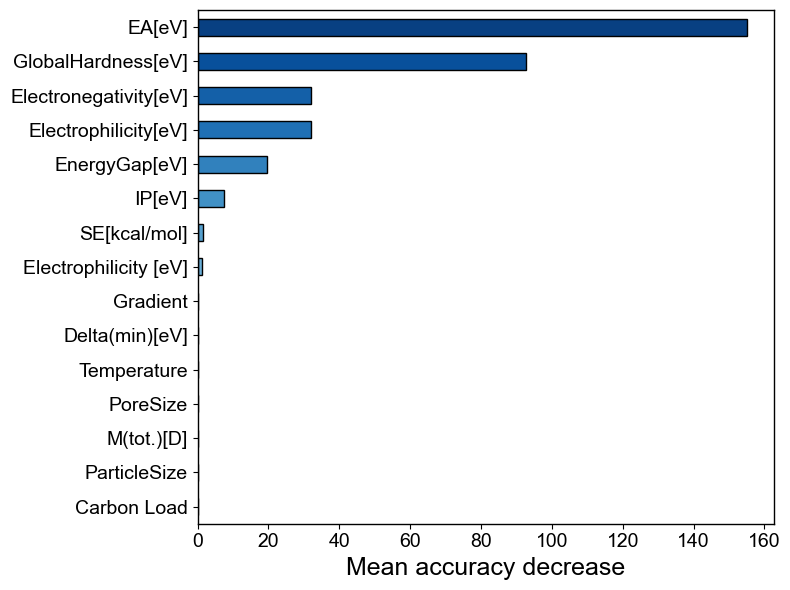

In [32]:
result = permutation_importance(
    rg_new, X_tot, y_tot, n_repeats=1000, random_state=42, n_jobs=2)

rg_importances = pd.Series(result.importances_mean, index=descriptors).sort_values(ascending=True)
index=rg_importances.index

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig = plt.figure(figsize=(8,6))
ax1=plt.subplot()
pallete=sns.color_palette("Blues",15)
rg_importances.plot.barh(color=pallete , ax=ax1, edgecolor='black')
# ax1.set_title("Feature importances using permutation on full model")
ax1.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('./Plots/Ridge Regression/feature_importance_Ridge.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight


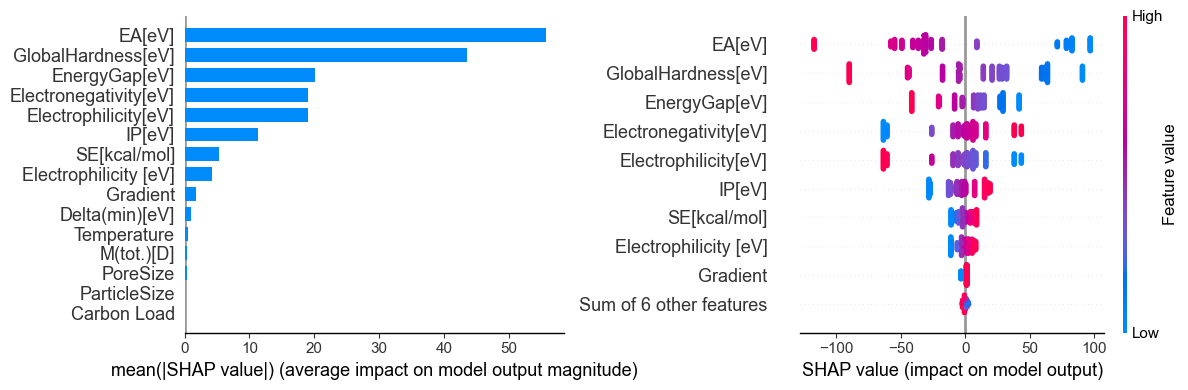

In [33]:
#######################################SHAP PLOTS##############################################
import shap
#   shap.initjs()
fig = plt.figure()

# compute SHAP values
explainer = shap.Explainer(rg_new.predict,X_train,feature_names=descriptors)
shap_values = explainer(X_train,)

ax0 = fig.add_subplot(121)
shap.summary_plot(shap_values, plot_type='bar', feature_names=descriptors, show=False)

ax2 = fig.add_subplot(122)
shap.plots.beeswarm(shap_values,show=False)

plt.gcf().set_size_inches(12,4)
plt.tight_layout() 
plt.show()

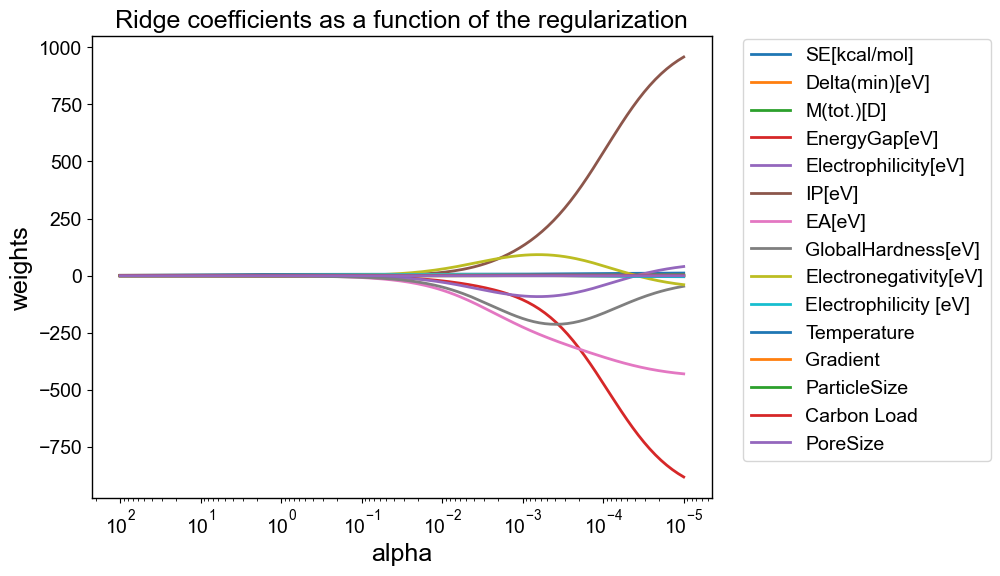

In [34]:
n_alphas = 200 # number of alpha
alphas = np.logspace(-5, 2, n_alphas)

coefs = []

for a  in alphas:
    ridge = make_pipeline(StandardScaler(), Ridge(alpha=a, fit_intercept=False)) 
    ridge.fit(X_train, y_train)
    coefs.append(ridge.named_steps['ridge'].coef_)
    


ax = plt.gca()
ax.plot(alphas, coefs,label=descriptors)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(loc=(1.05,0.08))
plt.show()


# **Result**

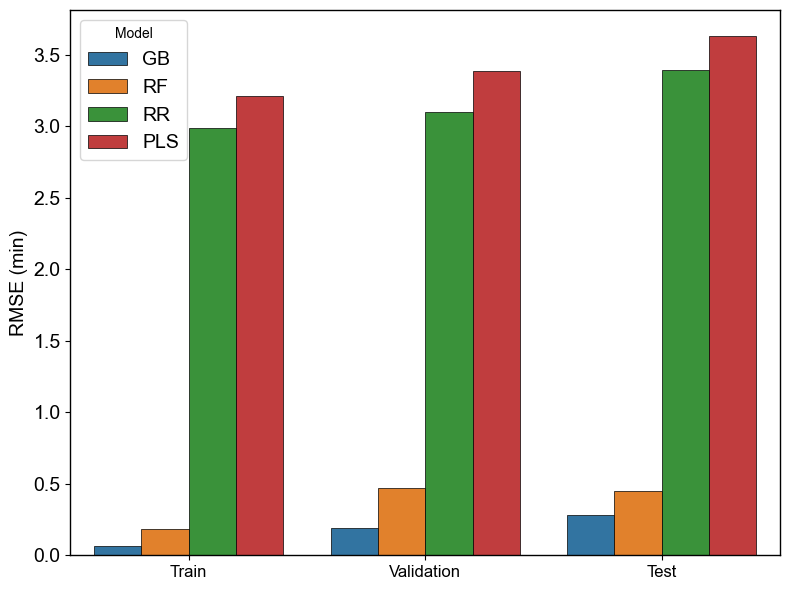

In [35]:
# improt Data
from sklearn.preprocessing import binarize


result=pd.read_csv('result.csv')
xlabels = ['Train', 'Validation', 'Test']
g=sns.barplot(x='rmse', y='RMSE (min)', hue='Model',data=result,edgecolor="black", linewidth=0.5, )
plt.xticks(np.arange(3), xlabels, fontsize=12)
plt.xlabel("", fontsize=12)
plt.ylabel("RMSE (min)", fontsize=14)
plt.tight_layout()
plt.grid(False)

plt.savefig("./plots/RMSE.svg", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

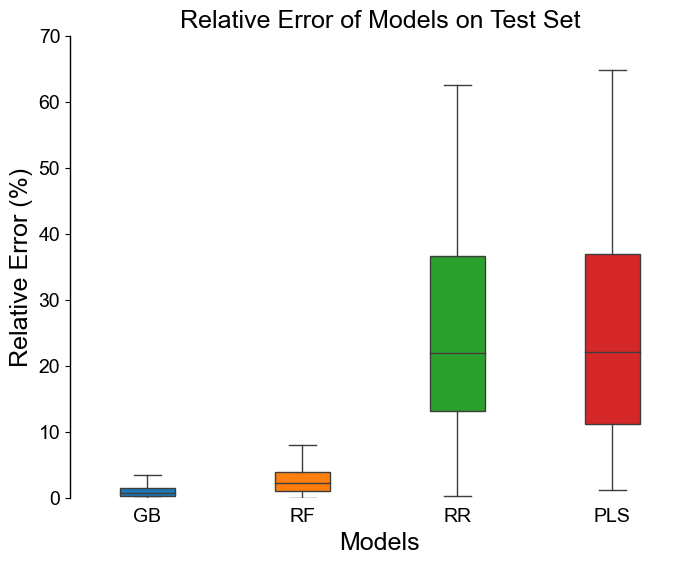

In [36]:
# error prediction on hold out set data
from turtle import width


models=[GB_new,rf_new,rg_new,pls]
names=['GB','RF','RR','PLS']
errors= np.zeros((108, len(names)))
for i, model in enumerate(models):
    y_predd=model.predict(X_test)
    error=(abs(y_test - y_predd.ravel())/y_test)*100
    errors[:,i]=error

error_list = pd.DataFrame(errors, columns=names)


ax=sns.boxplot(data=error_list, width=0.35, linewidth=1, fliersize=0, saturation=1)
# remove spines  
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)   
ax.spines["bottom"].set_visible(False)
plt.tick_params(bottom = False) 

# x and y label
plt.ylabel('Relative Error (%)' )
plt.xlabel('Models')
plt.title('Relative Error of Models on Test Set')
plt.ylim(0,70)
plt.savefig('./Plots/Relative Error of Models on Test Set.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()


In [52]:
error_list.describe()

,GB,RF,RR,PLS
count,108.000000,108.000000,108.000000,108.000000
mean,1.436767,3.979278,30.088914,31.107355
std,2.147517,5.687320,28.567086,31.834787
min,0.008286,0.010922,0.288107,1.141683
25%,0.210282,1.040610,13.211044,11.153305
50%,0.695806,2.168131,21.909006,22.132771
75%,1.544677,3.964203,36.619976,36.908807
max,12.991435,27.285542,165.260002,144.849728


So far we did:
> ☑ Train each model on the training set.

> ☑ Evaluate each trained model’s performance on the validation set.
validation data helps  make a better decision about which model is “The Best.”

> ☑ Choose the model with the best validation set performance.

 it can be seen that `Gradient Boosting` outperformed Other models, therfore Now:
 
> ☐ Evaluate this chosen model on the test set
> 
we should run our best Model  on the test set to see its performance, once.